# Imports

In [99]:
from torch.distributions.normal import Normal
import numpy as np
import torch
import plotly.express as px
import torch
import plotly.graph_objects as go
import scipy
import random

In [100]:
from tqdm.notebook import tqdm as tq
import matplotlib.lines as lines

## utils

In [101]:
def calc_js(hist, probs):
    len(probs)
    kl1 = np.dot(hist, np.log((hist + 1e-7) / (probs+1e-7)))
    kl2 = np.dot(probs, np.log((probs + 1e-7)  / (hist + 1e-7)))
    return 0.5*kl1+0.5*kl2

In [102]:
def get_histograms(hmc_sample, svs_sample, mucola_sample, dim=2):
    hmc_hist = np.histogram(hmc_sample, bins=np.arange(-0.5, 2**dim+0.5, 1), density=True)[0]
    svs_hist = np.histogram(svs_sample, bins=np.arange(-0.5, 2**dim+0.5, 1), density=True)[0]
    mucola_hist = np.histogram(mucola_sample, bins=np.arange(-0.5, 2**dim+0.5, 1), density=True)[0]
    
    return hmc_hist, svs_hist, mucola_hist

# Toy Example

In [103]:
data = np.asarray([[-0.5, -0.5], [-0.5, 0.5], [0.5, -0.5], [0.5, 0.5]])

In [104]:
x = data[:, 0]
y = data[:, 1]
data.tolist()
torch.tensor(data).float()

tensor([[-0.5000, -0.5000],
        [-0.5000,  0.5000],
        [ 0.5000, -0.5000],
        [ 0.5000,  0.5000]])

In [105]:
SIZE = 1.
points = data.tolist()
# Adding boundary points 
points.append([-SIZE*4, -SIZE*4])
points.append([-SIZE*4, SIZE*4])
points.append([SIZE*4, -SIZE*4])
points.append([SIZE*4, SIZE*4])

In [106]:
points = data.tolist()
points += [[-1.5, -1.5], [-1.5, -0.5], [-1.5, 0.5], [-1.5, 1.5],
                 [-0.5, -1.5], [0.5, -1.5], [-0.5, 1.5], [0.5, 1.5], 
                 [1.5, -1.5], [1.5, -0.5], [1.5, 0.5], [1.5, 1.5]]

In [107]:
data = points
num_extra_points = 12

# Visualization Tools

In [108]:
pink_color = '#CC6677'
yellow_color = '#DDCC77'
blue_color = '#88CCEE'
dblue_color = '#332288'
green_color = "#44AA99"

plot_layout_dict = {
'autosize': True,
'plot_bgcolor': '#EDEDED',  
'width': 700,
'font_family': "DejaVu Serif",
'font_size': 20, 
'legend_font_size': 18,
'legend': dict(
   yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.99,
    bgcolor='rgba(0,0,0,0)'
),
}

In [109]:
def add_js_traces_to_fig(xvalues, mucola_js, svs_js, hmc_js):
    fig = go.Figure()
    fig.add_trace(go.Scatter(
    x=xvalues,
    y = mucola_js,
    name="MuCoLa",
    marker=dict(
    color=pink_color,
    symbol="cross",
    ),
    ))
    
    fig.add_trace(go.Scatter(
    x=xvalues,
    y = svs_js,
    name="Voronoi Sampling",
    marker=dict(
    color=green_color,
    symbol="circle",
    ),
    ))
    fig.add_trace(go.Scatter(
    x=xvalues,
    y = hmc_js,
    name="HMC Sampling",
    marker=dict(
    color=blue_color,
    symbol="square",
    ),
    ))
    fig.update_layout(plot_layout_dict)
    return fig
    

In [110]:
def plot_js_results(hmc_samples, svs_samples, mucola_samples, k=4, probs=None):
    hmc_js = []
    svs_js = []
    mucola_js = []
    
    for temp, sam in hmc_samples.items():
        hmc_hist, svs_hist, mucola_hist = get_histograms(sam, svs_samples[temp], mucola_samples[temp])

        probs[:-12] = torch.softmax(energies[:-12] / temp, 0)

        hmc_js.append(calc_js(hmc_hist, probs[:-12]))
        svs_js.append(calc_js(svs_hist, probs[:-12]))
        mucola_js.append(calc_js(mucola_hist, probs[:-12]))

    temps = list(hmc_samples.keys())
    fig = add_js_traces_to_fig(temps, mucola_js, svs_js, hmc_js)
    fig.update_layout(
    xaxis_title="Temperature",
    yaxis_title="JS Divergence",
    legend_title="Sampling Method",
    ) 
    
    return fig, hmc_js, svs_js, mucola_js

In [111]:
def plot_js_resultsk(ks, hmc_samples, svs_samples, mucola_samples, temp=0.5):
    hmc_js = []
    svs_js = []
    mucola_js = []
    
    for k, sam in hmc_samples.items():
        hmc_hist, svs_hist, mucola_hist = get_histograms(sam, svs_samples[k], mucola_samples[k], dim=k)

        np.random.seed(1)
        energies = torch.tensor(np.random.uniform(low=0, high=5, size=2**k))
        probs = torch.softmax(energies / temp, 0)

        hmc_js.append(calc_js(hmc_hist, probs))
        svs_js.append(calc_js(svs_hist, probs))
        mucola_js.append(calc_js(mucola_hist, probs))
            
        
    fig = add_js_traces_to_fig(ks, mucola_js, svs_js, hmc_js)
    
    fig.update_layout(
    xaxis_title="k",
    yaxis_title="JS Divergence",
    legend_title="Sampling Method",
    ) 
    
    return fig, hmc_js, svs_js, mucola_js

## Voronoi - Visualization

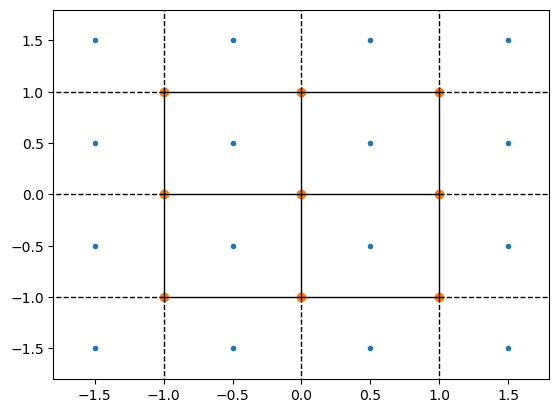

In [112]:
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt

vor = Voronoi(points)
fig = voronoi_plot_2d(vor)

## Defining Energies

In [113]:
embeds = torch.tensor(data)
embeds = embeds.float()

In [114]:
TEMPS = [0.25, 0.5, 0.75, 1., 1.5, 2.]
probs = torch.tensor([1e-15]*16)
energies = torch.tensor([0.5, 0.1, 1., 2.5]+[1e-15]*12)
for temp in TEMPS:
    probs[:-12] = torch.softmax(energies[:-12] / temp, 0)

## Functions

In [115]:
def project_embeds(e):
    # projects the embedding to the closest embedding in the vocab
    with torch.no_grad():
        diff = embeds - e
        dists = torch.sum(diff * diff, dim=1)
        projected_idx = torch.argmin(dists, dim=0)
        
        projected_e = embeds[projected_idx]
    return projected_idx, projected_e

In [116]:
def initialize(k=3):
    rand_idx = random.randint(0, k)
    return rand_idx, embeds[rand_idx].unsqueeze(0)

def energy_e_function(e2, max_len=0):
    # Returns the energies from the predefined potential energies
    e_idx, e = e2
    e = e.squeeze(0)
    for dim in range(e.shape[0]):
        if e[dim].item() > 1. or e[dim].item() < -1.:
            return -1 * torch.log(torch.tensor([1e-15])[0])
    return potential_energies[e_idx]

def hamiltonian(e2, p):
    # Computes the hamiltonian, which is the sum of potential and kinetic energies
    with torch.no_grad():
        p_energy =  energy_e_function(e2, max_len).mean() # -log_prob(..)
        k_energy =  torch.sum(p*p/2., -1).mean()
        
        return p_energy + k_energy

/var/folders/dp/h5b4qfjd099c9syhbmr_tl1w0000gn/T/ipykernel_60090/4033367866.py:1: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



# RHMC

In [117]:
def find_delta_u(e_s, p):
    # computes the difference in energies
    with torch.no_grad():
        e_t = e_s + 0.01 * p
        e_s_idx, e_s_proj = project_embeds(e_s)
        e_t_idx, e_t_proj = project_embeds(e_t)
        delta_u = energy_e_function((e_s_idx, e_s_proj), max_len).mean() - energy_e_function((e_t_idx, e_t_proj), max_len).mean()
        return delta_u
        
        
def find_discontinuity(e_s, e_t, p, t):
    # checks if the move from e_s (source) to e_t (target) crosses Voronoi boundaries
    # returns:
    # True (if the boundary is crossed)
    # the normal vector of the boundary
    # difference between the energies in the corresponding cells
    # the new position in the boundary of the cell (+ epsilon to avoid errors)
    
    with torch.no_grad():
        s_idx, e_s_proj = project_embeds(e_s)
        t_idx, e_t_proj = project_embeds(e_t)
        delta_en = energy_e_function((t_idx, e_t_proj)).mean() - \
                   energy_e_function((s_idx, e_s_proj)).mean()
        
        if delta_en > 1e-10:
            n = e_t_proj.flatten() - e_s_proj.flatten()
            mid = (e_t_proj.flatten() + e_s_proj.flatten()) / 2.
            new_t = (torch.dot(n, mid) - torch.dot(n, e_s.flatten())) / torch.dot(n, p)
            if not new_t or (abs(new_t) / eps_p) > (EPS_DISC + 0.005):
                print(abs(new_t) / eps_p)
                print("ERROR in discontinuity")
                return False, None, None, EPS_DISC
            return True, n, delta_en, (abs(new_t) / eps_p) + 0.005
        else:
            return False, None, None, EPS_DISC


def decompose(p, ref):
    # decompose the momentum (p) into two parts accroding to the reference vector
    p_perp = (torch.dot(p, ref) / torch.dot(ref, ref))*ref
    p_par = p - p_perp
    return p_perp, p_par

def refract_reflect(p, ref, delta_en):
    # reflects or refracts the momentum (p) based on the difference in energies
    p_perp, p_par = decompose(p, ref)
    perp_norm = torch.dot(p_perp, p_perp)
    if  perp_norm > 2 * delta_en: #REFRACT
        p_perp = torch.sqrt(perp_norm - 2*delta_en) * (p_perp / torch.sqrt(perp_norm))
    else: #REFLECT
        p_perp = -1 * p_perp
    
    p = p_par + p_perp
    
    return p


def simulate_rhmc(e, p):
    # Voronoi sampling function, implemented based on RHMC
    t = 0
    
    e = e.squeeze(0)
    p = p.squeeze(0)
    
    
    while t < 1.:
        e_new = e.clone() + eps_p * EPS_DISC * p
        disc_res = find_discontinuity(e, e_new, p.flatten(), t)
        if not disc_res:
            return None
        is_discont, ref, delta_en, delta_t = disc_res
        t = min(1., t + delta_t)
            
        if is_discont: # adjust the momentum
            e_new = e.clone() + eps_p * delta_t * p
            p = refract_reflect(p.clone().flatten(), ref, delta_en)
        
        e = e_new
        
    return e.unsqueeze(0)

In [118]:
def leapfrog_update(project, step_size, e_proj, e, p, baseline=True):
    for _ in range(1): # we do only one leapfrog to make this close to what we do in real-world NLP settings
        
        p_mid = p.clone() 

        if baseline:
            e_next = e + eps_p * p_mid
        else:
            e_next = simulate_rhmc(e, p_mid)
            if e_next is None:
                return None
            
        
        with torch.no_grad():
            e_next_proj_idx, e_next_proj = project_embeds(e_next.data.detach())

        p_next = p_mid.clone() 
        
        e_proj, e, p = e_next_proj.data.detach(), e_next, p_next  
    
    if project:
        return e_proj, e_next_proj_idx, e_proj, p
    else:
        return e_proj, e_next_proj_idx, e, p 

In [119]:
def run_hmc(is_baseline=True, project=False):
    global eps_p
    ppls = []
    samples = []

    for _ in tq(range(number_of_samples)):
        eps_p = EPS_P

        e_idx, e = initialize()
        e_proj = e.clone()

        i = 0

        with torch.enable_grad():
            for _ in range(steps):
                p = torch.normal(mean=0.0, std=noise_std, size=e.size()).to(device)
                res = leapfrog_update(project, step_size, 
                                      e_proj.clone(), e.clone(), p.clone(), 
                                      baseline=is_baseline)
                if res is None:
                    continue
                e_next_proj, e_next_idx, e_next, p_next = res

                h1 = hamiltonian((e_idx, e), p)
                h2 = hamiltonian((e_next_idx, e_next), p_next)
                deltah = h1 - h2

                p_accept = min(1, torch.exp(deltah))
                
                coin = np.random.rand()

                if coin < p_accept:
                    e_proj, e, e_idx = e_next_proj, e_next, e_next_idx
                    samples.append(e_idx.cpu().numpy().item())
                    
    return samples

# Run Toy Examples

setting the hyperparameters

In [120]:
TEMPS = [0.25, 0.5, 0.75, 1., 1.5, 2.]
steps = 500 
number_of_samples = 200 
log_steps = 900 # never
device = "cpu"
step_size = 0.1
max_len = 0
EPS_P = 0.1 
noise_std = 2.5 
EPS_DISC = 0.1

In [121]:
svs_samples = {}
hmc_samples = {}
mucola_samples = {}
show_fig=False
for temp in tq(TEMPS):
    
    probs[:-12] = torch.softmax(energies[:-12] / temp, 0)
#     print(["{:.2f}".format(p) for p in probs[:-12]])
    potential_energies = -1 * torch.log(probs)
    if show_fig:
        fig = create_vor_fig()
    
    svs_samples[temp] = run_hmc(is_baseline=False)
    hmc_samples[temp] = run_hmc(is_baseline=True)
    mucola_samples[temp] = run_hmc(is_baseline=True, project=True)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Let's visualize the results and compare the JS divergences between different methods

In [122]:
fig, js, op_js, proj_js = plot_js_results(hmc_samples, svs_samples, mucola_samples, probs=probs)
fig

## Comparing the distribution of samples
To answer questions like: does the algorithm get stuck in one Voronoi cell and over samples an element, or does it undersamples some elements, one can also look at which samples each algorithm takes and compare that to the true distribution of samples. 

In [147]:
def get_reference_samples(temp):
    probs[:-12] = torch.softmax(energies[:-12] / temp, 0)
    p = np.asarray(probs[:-12]).astype('float64')
    p /= p.sum()
    ref_dist = np.random.choice(4, number_of_samples, p=p)
    return ref_dist

In [148]:
fig = go.Figure()
temp = 0.25
ref_dist = get_reference_samples(temp)
fig.add_trace(go.Histogram(x=[str(s) for s in mucola_samples[temp]], histnorm='probability density', name='MuCoLa', marker_color=pink_color))
fig.add_trace(go.Histogram(x=[str(s) for s in hmc_samples[temp]], histnorm='probability density', name='HMC Sampling', marker_color=blue_color))
fig.add_trace(go.Histogram(x=[str(s) for s in svs_samples[temp]], histnorm='probability density', name='Voronoi Sampling', marker_color=green_color))
fig.add_trace(go.Histogram(x=ref_dist, histnorm='probability density', name='Reference', marker_color='silver'))

fig.update_layout(plot_layout_dict)
    
fig.update_layout(
xaxis_title="Item",
yaxis_title="Probability",
) 
fig.update_xaxes(categoryorder='array', categoryarray= ['0','1','2','3'])
fig.show()

# Hypercubes
Let's generalize from 4 points in 2D to $2^k$ points in k dimensions. 

In [80]:
import itertools
import numpy as np
import scipy


def generate_arrays(k):
    values = [-0.5, 0.5]
    all_combinations = list(itertools.product(values, repeat=k))
    return np.array(all_combinations)

1024


Just checking if data generation works, it should give us $2^k$ points for $k$ dimension.

In [81]:
k = 10  # Replace this with the desired length of the arrays
result = generate_arrays(k)
print(len(result))

1024


setting the hyperparameters

In [84]:
steps = 500 
number_of_samples = 100 
log_steps = 900
device = "cpu"
step_size = 0.1 
max_len = 0
EPS_P = 0.1 
noise_std = 2.5 
EPS_DISC = 0.1
DIMENSIONS = [2, 4, 6, 8]

In [85]:
svs_samples = {}
hmc_samples = {}
mucola_samples = {}
show_fig=False
temp = 0.5
for k in DIMENSIONS:
    data = generate_arrays(k)
    np.random.seed(1) # set seed to get the same probabilities when visualizing the results
    energies = torch.tensor(np.random.uniform(low=0, high=5, size=2**k))
    embeds = torch.tensor(data)
    embeds = embeds.float()
    
    probs = torch.softmax(energies / temp, 0)
    print(["{:.2f}".format(p) for p in probs])
    potential_energies = -1 * torch.log(probs)
    if show_fig:
        fig = create_vor_fig()
    
    svs_samples[k] = run_hmc(is_baseline=False)
    hmc_samples[k] = run_hmc(is_baseline=True)
    mucola_samples[k] = run_hmc(is_baseline=True, project=True)

['0.05', '0.94', '0.00', '0.01']


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

['0.01', '0.13', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.01', '0.02', '0.01', '0.09', '0.00', '0.64', '0.00', '0.08']


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

['0.00', '0.01', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.01', '0.00', '0.06', '0.00', '0.01', '0.00', '0.00', '0.00', '0.00', '0.03', '0.14', '0.00', '0.01', '0.06', '0.07', '0.00', '0.00', '0.00', '0.06', '0.00', '0.00', '0.13', '0.00', '0.01', '0.00', '0.01', '0.04', '0.00', '0.02', '0.18', '0.02', '0.00', '0.02', '0.00', '0.00', '0.08', '0.00', '0.00', '0.00', '0.00', '0.01', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.01', '0.00', '0.00', '0.01', '0.00']


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.01', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.03', '0.00', '0.00', '0.01', '0.01', '0.00', '0.00', '0.00', '0.01', '0.00', '0.00', '0.02', '0.00', '0.00', '0.00', '0.00', '0.01', '0.00', '0.00', '0.03', '0.00', '0.00', '0.00', '0.00', '0.00', '0.01', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.02', '0.00', '0.01', '0.00', '0.00', '0.01', '0.00', '0.00', '0.02', '0.00', '0.00', '0.00', '0.01', '0.00', '0.00', '0.00', '0.00', '0.01', '0.00', '0.02', '0.00', '0.00', '0.00', '0.02', '0.00', '0.00', '0.00', '0.00', '0.01', '0.00', '0.00', '0.00', '0.00', '0.00', '0.01', '0.00', '0.01', '0.00', '0.00', '0.02', '0.00', '0.03', '0.00', '0.00', '0.02', '0.00', '0.00', '0.00', '0.00', '0.02', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.01',

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [96]:
fig, js, op_js, proj_js = plot_js_resultsk(DIMENSIONS, hmc_samples, svs_samples, mucola_samples)
fig